In [37]:
import warnings
warnings.filterwarnings("ignore")
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import Diagonal
import matplotlib.pyplot as plt

In [38]:
def init(circuit, qubits):
    for q in qubits:
        circuit.h(q)
    return circuit

def generate_combinations():
    friends = ['Manas', 'Charlie', 'Ayaan', 'Abhinav', 'Harsh']
    possible_comb = []
    for i in range(2**len(friends)):
        comb = format(i, '0' + str(len(friends)) + 'b')
        if (comb[0] == '1' and comb[1] == '1') and not (comb[2] == '1' and comb[3] == '1') and comb[4] == '1':
            possible_comb.append(comb)
    return possible_comb


oracle = QuantumCircuit(5, name='oracle')
qubits = list(range(5))
possible_comb = generate_combinations() 
mark_comb = []

for i in range(len(possible_comb)):
    mark_comb = Statevector.from_label(possible_comb[i])
    phase = (-1)**mark_comb.data
    d_mat = Diagonal(phase)
    oracle.append(d_mat, qubits)

oracle.draw()

┌───────────┐┌───────────┐┌───────────┐
q_0: ┤0          ├┤0          ├┤0          ├
     │           ││           ││           │
q_1: ┤1          ├┤1          ├┤1          ├
     │           ││           ││           │
q_2: ┤2 Diagonal ├┤2 Diagonal ├┤2 Diagonal ├
     │           ││           ││           │
q_3: ┤3          ├┤3          ├┤3          ├
     │           ││           ││           │
q_4: ┤4          ├┤4          ├┤4          ├
     └───────────┘└───────────┘└───────────┘

In [39]:
def diffuser(qubits):
    amp = QuantumCircuit(5, name='amplifier')
    amp.h(qubits)
    amp.x(qubits)
    #flipping the amplitudes
    inv = Statevector.from_label('11111')
    inv = Diagonal((-1)**inv.data)
    amp.append(inv, qubits)
    
    amp.x(qubits)
    amp.h(qubits)
    return amp

amp = diffuser(qubits)
amp.draw()

┌───┐┌───┐┌───────────┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤0          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_1: ┤ H ├┤ X ├┤1          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_2: ┤ H ├┤ X ├┤2 Diagonal ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_3: ┤ H ├┤ X ├┤3          ├┤ X ├┤ H ├
     ├───┤├───┤│           │├───┤├───┤
q_4: ┤ H ├┤ X ├┤4          ├┤ X ├┤ H ├
     └───┘└───┘└───────────┘└───┘└───┘

Final Circuit Diagram


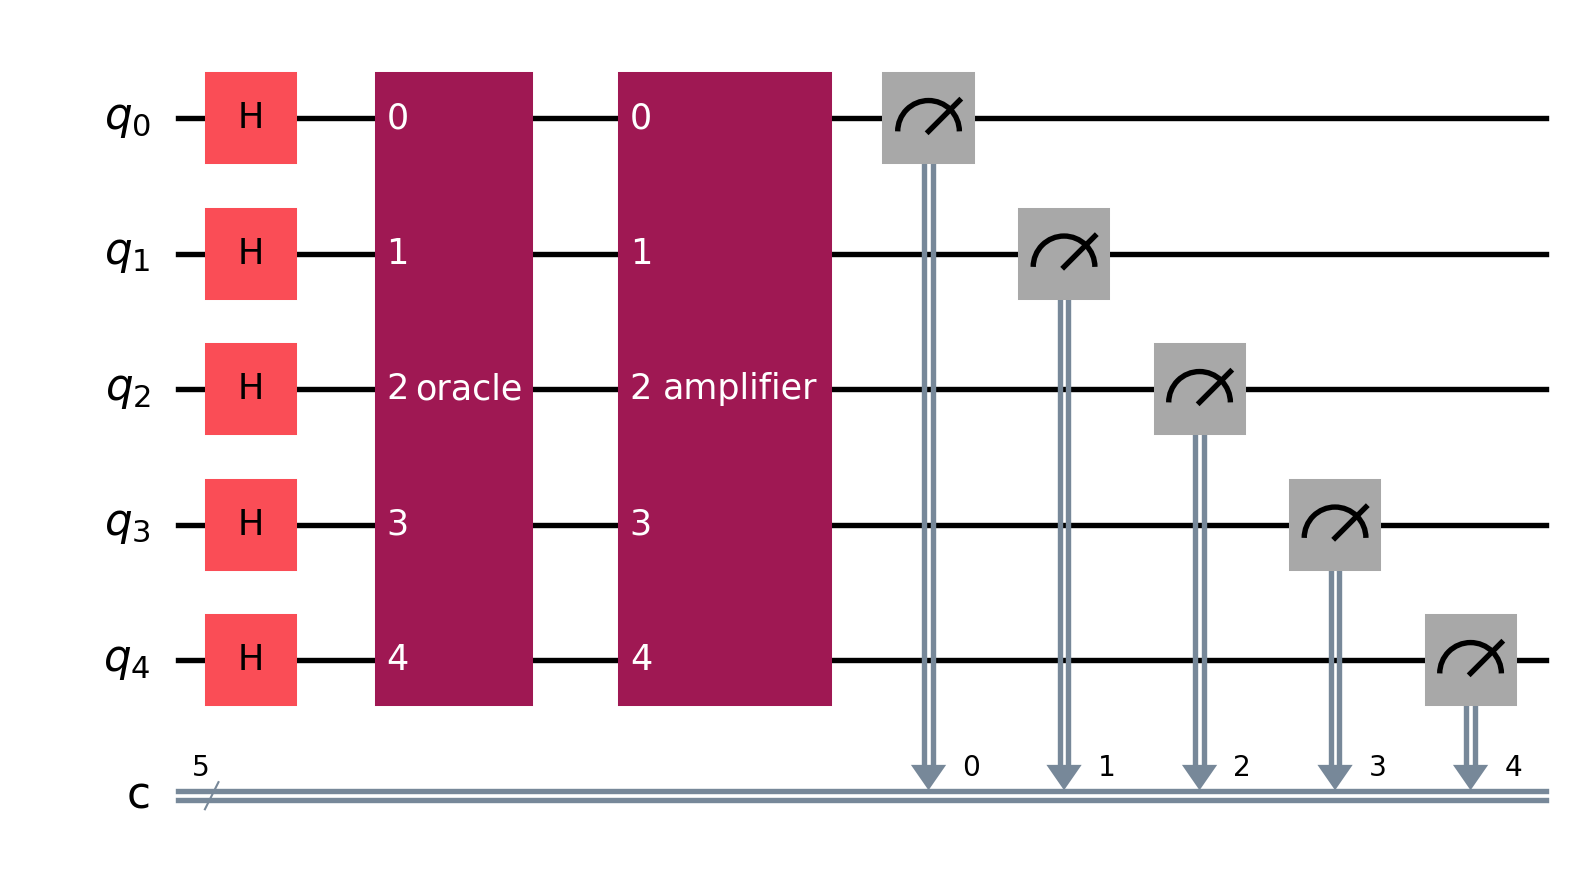

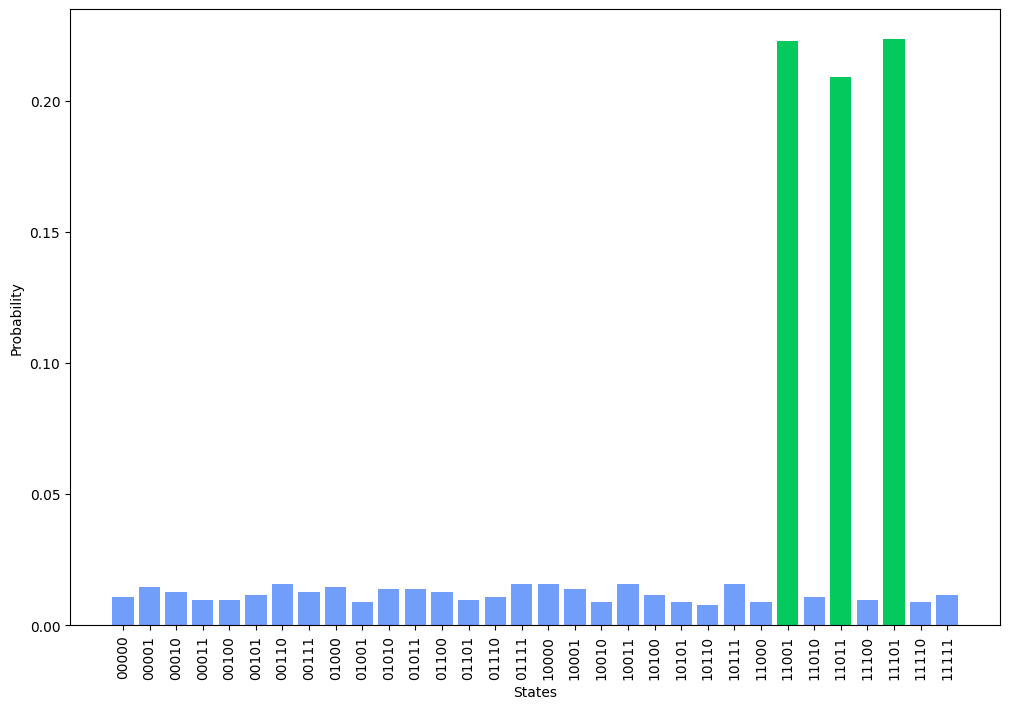

In [41]:
gc = QuantumCircuit(5, 5)
gc = init(gc, qubits)
gc.append(oracle, qubits)
gc.append(amp, qubits)

qasm_sim = Aer.get_backend('qasm_simulator')
gc.measure(qubits, qubits)
fig = plt.figure(figsize=(20,15))
gc.draw(output='mpl', ax=fig.gca()) 
print("Final Circuit Diagram")

job_sim = qasm_sim.run(transpile(gc, qasm_sim), shots=1024)
res = job_sim.result()
counts = res.get_counts(gc)
s_counts = dict(sorted(counts.items()))
total_shots = sum(s_counts.values())

probabilities = {state: count / total_shots for state, count in s_counts.items()}
colors = ['#04c95c' if state in possible_comb else '#709efa' for state in probabilities.keys()]

plt.figure(figsize=(12, 8))
plt.xlabel('States')
plt.ylabel('Probability')
plt.bar(range(len(probabilities)), list(probabilities.values()), align='center', color=colors)
plt.xticks(range(len(probabilities)), list(probabilities.keys()), rotation='vertical')
plt.show()